In [144]:
!git clone https://github.com/YasirHabib/The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning.git

fatal: destination path 'The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning' already exists and is not an empty directory.


In [145]:
!ls The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [0]:
path = 'The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data'
train_dir = os.path.join(path, 'driving_log.csv')

In [149]:
df_data = pd.read_csv(train_dir, header = None)
df_data.head()

,0,1,2,3,4,5,6
0,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000081
1,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
2,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
3,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
4,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000082


In [150]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df_data = pd.read_csv(train_dir, names = columns)
df_data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000081
1,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
2,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
3,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
4,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000082


In [151]:
def path_split(path):
  head, tail = ntpath.split(path)
  return tail

df_data['center'] = df_data['center'].apply(path_split)
df_data['left'] = df_data['left'].apply(path_split)
df_data['right'] = df_data['right'].apply(path_split)

df_data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_11_30_13_10_08_292.jpg,left_2019_11_30_13_10_08_292.jpg,right_2019_11_30_13_10_08_292.jpg,0.0,0.0,0.0,0.000081
1,center_2019_11_30_13_10_08_402.jpg,left_2019_11_30_13_10_08_402.jpg,right_2019_11_30_13_10_08_402.jpg,0.0,0.0,0.0,0.000078
2,center_2019_11_30_13_10_08_508.jpg,left_2019_11_30_13_10_08_508.jpg,right_2019_11_30_13_10_08_508.jpg,0.0,0.0,0.0,0.000078
3,center_2019_11_30_13_10_08_609.jpg,left_2019_11_30_13_10_08_609.jpg,right_2019_11_30_13_10_08_609.jpg,0.0,0.0,0.0,0.000078
4,center_2019_11_30_13_10_08_718.jpg,left_2019_11_30_13_10_08_718.jpg,right_2019_11_30_13_10_08_718.jpg,0.0,0.0,0.0,0.000082


[ 130    6    1   17   74   17    3   23  323   49    2   63 3612   42
    0   19  163   34    1   16   42   20    1    0   81]
[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


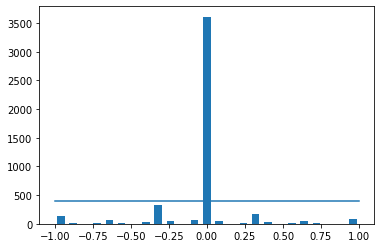

In [152]:
num_bins = 25
hist, bins = np.histogram(df_data['steering'], num_bins)   # bins is the interval across which the data is distributed
print(hist)
print(bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(center)
plt.bar(center, hist, width=0.05)
samples_per_bin = 400
plt.plot((np.min(df_data['steering']), np.max(df_data['steering'])), (samples_per_bin, samples_per_bin))

In [153]:
# print('total data:', len(df_data))      total data: 4739
# print ('steering data:', len(df_data['steering']))        steering data: 4739

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(df_data['steering'])):
    if df_data['steering'][i] >= bins[j] and df_data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  # print(len(list_))  0 0 0 0 0 0 0 0 0 0 0 0 3212 0 0 0 0 0 0 0 0 0 0 0 0
  remove_list.extend(list_)

print('removed:', len(remove_list))        # 3612 - 400
df_data.drop(df_data.index[remove_list], inplace=True)
print('remaining:', len(df_data))

removed: 3212
remaining: 1527


[130   6   1  17  74  17   3  23 323  49   2  63 400  42   0  19 163  34
   1  16  42  20   1   0  81]


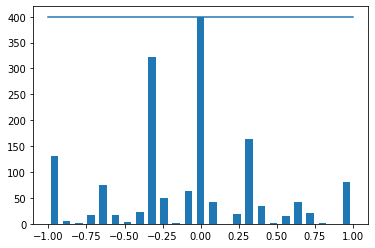

In [154]:
hist, _ = np.histogram(df_data['steering'], num_bins)
print(hist)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df_data['steering']), np.max(df_data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
# print(df_data.iloc[0])

# center      center_2019_11_30_13_10_08_609.jpg
# left          left_2019_11_30_13_10_08_609.jpg
# right        right_2019_11_30_13_10_08_609.jpg
# steering                                     0
# throttle                                     0
# reverse                                      0
# speed                              7.83659e-05
# Name: 3, dtype: object

Training Samples: 1221
Valid Samples: 306


Text(0.5, 1.0, 'Validation set')

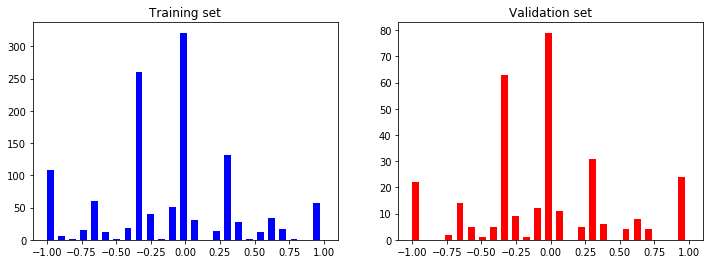

In [156]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    # print(len(df))         # 1527
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # print(center)             center_2019_11_30_13_10_08_826.jpg
    image_path.append(os.path.join(datadir, center.strip()))
    # print(image_path[0])      The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data/IMG/center_2019_11_30_13_10_08_826.jpg
    steering.append(float(indexed_data[3]))
    # # left image append
    # image_path.append(os.path.join(datadir, left.strip()))
    # steering.append(float(indexed_data[3])+0.15)
    # # right image append
    # image_path.append(os.path.join(datadir, right.strip()))
    # steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(path + '/IMG', df_data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')